In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,classification_report, roc_curve, log_loss, brier_score_loss, roc_auc_score
from timeit import default_timer as timer

In [3]:
#Cross Validation Function

def CrossVal(model):

    start_cross_val = timer()

    scores = cross_val_score(model, X_train, y_train)

    print('Mean Accuracy:',round(scores.mean()*100,2),'%')
    print('Accuracy Standard Deviation',round(scores.std()*100,2),'%')

    end_cross_val = timer()
    print('Cross Validation Time:', round(end_cross_val - start_cross_val,1), 'seconds')

In [4]:
#Full Training Set Validation Function

def TrainVal(model, df_categorical, df_numerical, df_y):
    
    start_preprocessing = timer()

    #Create dummy columns for categorical features
    model_df = pd.get_dummies(df_categorical,
                              drop_first = True)

    #Add numerical features to model dataframe
    model_df = pd.concat([model_df, df_numerical], axis = 1)

    #Encode prediction variable and add to dataframe
    ord_enc = OrdinalEncoder().fit(df_y)
    y = np.ravel(ord_enc.transform(df_y))
    
    #Create scaled training and validation datasets
    X = StandardScaler().fit_transform(model_df)

    X_train, X_validation, y_train, y_validation = train_test_split(X, y, stratify = y, random_state = 33)

    end_preprocessing = timer()
    print('Preprocessing Time:', round(end_preprocessing - start_preprocessing,1), 'seconds')
    
    #Train model passed to function
    start_training = timer()

    model.fit(X_train, y_train)

    end_training = timer()
    print('Training Time:', round(end_training - start_training,1), 'seconds')

    #Use trained model to predict test results
    start_prediction = timer()

    y_pred = model.predict(X_validation)
    y_pred_prob = model.predict_proba(X_validation)[:,1]

    end_prediction = timer()
    print('Prediction Time:', round(end_prediction - start_prediction,1), 'seconds')

    #Output test reports
    start_reports = timer()

    print('Confusion Matrix:\n', confusion_matrix(y_validation, y_pred))
    print('Classification Report:\n', classification_report(y_validation, y_pred))
    print('Accuracy:', round(model.score(X_validation, y_validation) *100,2), "%")
    print('Log Loss:', log_loss(y_validation, y_pred_prob))
    print('Brier Score Loss:', brier_score_loss(y_validation, y_pred_prob))

    fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    print('ROC AUC Score:', roc_auc_score(y_validation, y_pred_prob))
    
    forest_feature_importance = pd.DataFrame(zip(model_df.columns,model.feature_importances_))
    forest_feature_importance.sort_values(1, inplace = True)
    forest_feature_importance.reset_index(inplace = True, drop = True)

    plt.bar(forest_feature_importance[0][-20:],forest_feature_importance[1][-20:])
    plt.xticks(rotation = 'vertical')
    plt.title('20 Largest Importances')
    plt.show()

    plt.bar(forest_feature_importance[0][0:20],forest_feature_importance[1][0:20])
    plt.xticks(rotation = 'vertical')
    plt.title('20 Smallest Importances')
    plt.show()
    
    proba_df = pd.DataFrame(y_validation, columns = ['Solved'])
    proba_df['Predicted Probability'] = model.predict_proba(X_validation)[:,1]
    
    #The below bins by Predicted Probability
    bins = np.arange(0,1.05,0.05)
    labels = ['0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5',
              '0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1']
    proba_df['Bin'] = pd.cut(proba_df['Predicted Probability'], bins = bins, labels = labels)
    proba_df.reset_index(drop = True, inplace = True)
    chart_df = pd.DataFrame(proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean())
    chart_df['Count'] = proba_df.groupby('Bin')['Solved'].count()
    chart_df.reset_index(inplace = True)
    chart_df.columns = ['Bin', 'Actual', 'Predicted', 'Count']

    print(chart_df)
    
    plt.bar(chart_df.Bin, chart_df.Count)
    plt.xticks(rotation = 45)
    plt.title('Frequency of Test Cases by Predicted Clearance Probability')
    plt.xlabel('Case Clearance Probability')
    plt.ylabel('Count')
    plt.show()
    
    plt.scatter(chart_df.Bin, chart_df.Actual, label = 'Actual', alpha = 1)
    plt.scatter(chart_df.Bin, chart_df.Predicted, color = 'r', marker = 'D', label = 'Predicted', alpha = 0.75)
    plt.legend()
    plt.title('Actual and Predicted Clearance Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin (Range = Value - 5% to Value)')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Clearance Rate')
    plt.show()

    plt.scatter(chart_df.Predicted, chart_df.Actual)
    plt.plot([0,1],[0,1], linestyle = '--', color = 'g')
    plt.title('Actual vs. Predicted Clearance Rate by 5% bin')
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],rotation = 45)
    plt.xlabel('Predicted')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Actual')
    plt.show()

    plt.bar(chart_df.Bin, chart_df.Actual - chart_df.Predicted,)
    plt.title('Actual - Predicted Clearance Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin (Range = Value - 5% to Value)')
    plt.yticks([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])
    plt.ylabel('Delta Clearance Rate')
    plt.show()
    
    binned_sum_of_squares = sum(((chart_df.Actual - chart_df.Predicted).fillna(0)*100) ** 2)
    print('Sum of Squared Binned Residuals:', binned_sum_of_squares)

    end_reports = timer()
    print('Reporting Time:', round(end_reports - start_reports,1), 'seconds')

In [5]:
#murders_full = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_short.csv')
murders_no_unknowns = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns.csv')
#murders_unknown_ethnic = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns_except_VicEthnic.csv')

In [6]:
murders_no_unknowns.Solved.value_counts()

Yes    220148
No      88813
Name: Solved, dtype: int64

In [7]:
# Balance

solved_count, unsolved_count = murders_no_unknowns.Solved.value_counts()
solved = murders_no_unknowns[murders_no_unknowns.Solved == 'Yes']
unsolved = murders_no_unknowns[murders_no_unknowns.Solved == 'No']
solved_sample = solved.sample(unsolved_count)

murders_no_unknowns = pd.concat([unsolved, solved_sample], axis = 0)

murders_no_unknowns.Solved.value_counts()

Yes    88813
No     88813
Name: Solved, dtype: int64

Models using no_unknowns (smallest and cleanest) dataset (with MSA excluded for now):

Preprocessing Time: 1.9 seconds


C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training Time: 140.3 seconds
Prediction Time: 14.7 seconds
Confusion Matrix:
 [[15369  6835]
 [ 8390 13813]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22204
         1.0       0.67      0.62      0.64     22203

    accuracy                           0.66     44407
   macro avg       0.66      0.66      0.66     44407
weighted avg       0.66      0.66      0.66     44407

Accuracy: 65.71 %
Log Loss: 0.6192442948388956
Brier Score Loss: 0.2152248576899311


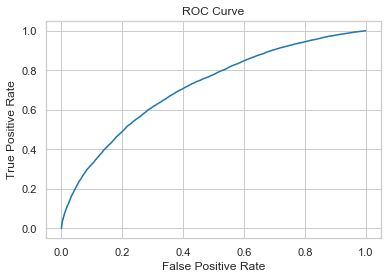

ROC AUC Score: 0.7144387501926691


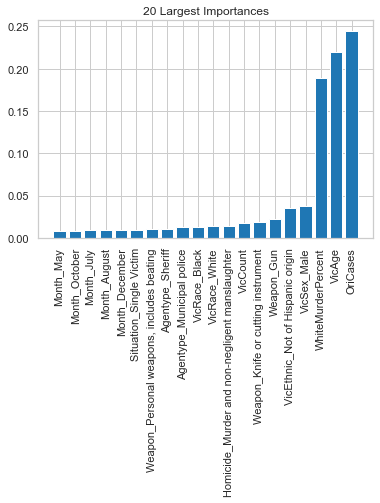

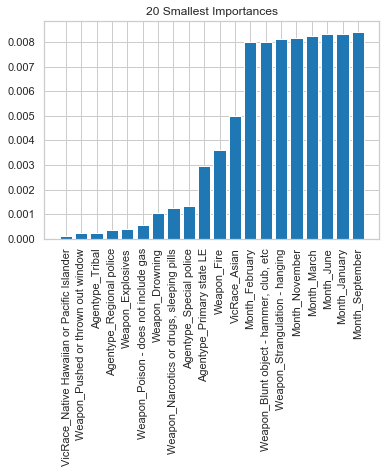

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted
0   0.05  0.000000   0.045406
1    0.1  0.176471   0.084620
2   0.15  0.155405   0.128863
3    0.2  0.180952   0.176119
4   0.25  0.205181   0.226851
5    0.3  0.258093   0.277461
6   0.35  0.293990   0.326615
7    0.4  0.387116   0.374597
8   0.45  0.412414   0.424104
9    0.5  0.481300   0.473970
10  0.55  0.535934   0.524475
11   0.6  0.601055   0.574568
12  0.65  0.632075   0.624349
13   0.7  0.675271   0.674237
14  0.75  0.739149   0.724530
15   0.8  0.792057   0.774302
16  0.85  0.821012   0.823740
17   0.9  0.882427   0.873336
18  0.95  0.918103   0.921483
19     1  0.953846   0.960265


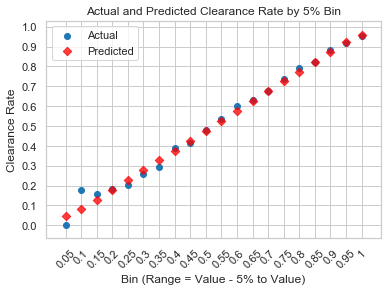

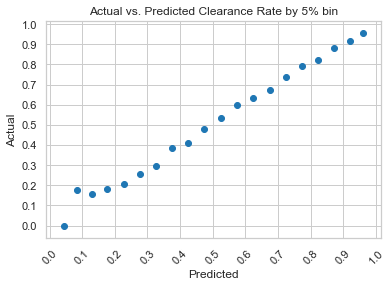

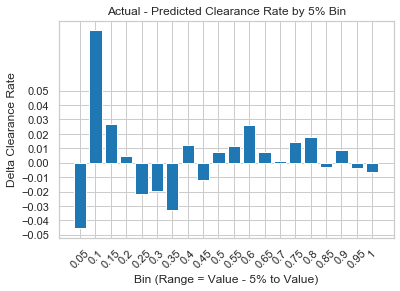

Binned Sum of Squares: 0.015047644507819688
Reporting Time: 18.6 seconds


In [23]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[['Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon']],
                                                drop_first = True)

df_numerical = murders_no_unknowns[['VicAge','VicCount','OriCases','WhiteMurderPercent']]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

(177626,)
Preprocessing Time: 0.7 seconds
Training Time: 136.0 seconds
Prediction Time: 14.4 seconds
Confusion Matrix:
 [[15377  6827]
 [ 8389 13814]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22204
         1.0       0.67      0.62      0.64     22203

    accuracy                           0.66     44407
   macro avg       0.66      0.66      0.66     44407
weighted avg       0.66      0.66      0.66     44407

Accuracy: 65.74 %
Log Loss: 0.6175594796050023
Brier Score Loss: 0.21459000680875143


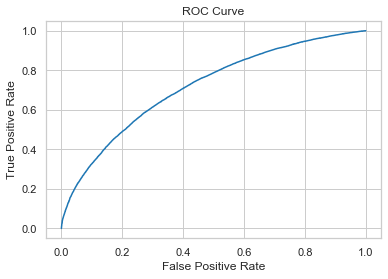

ROC AUC Score: 0.7166468052242239


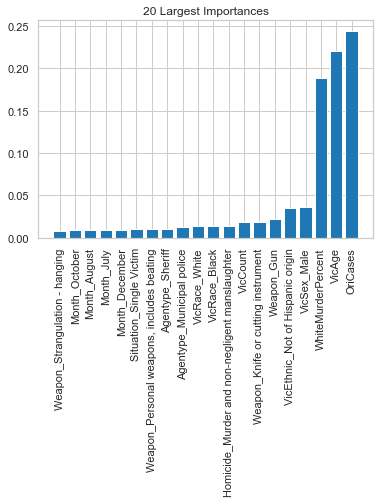

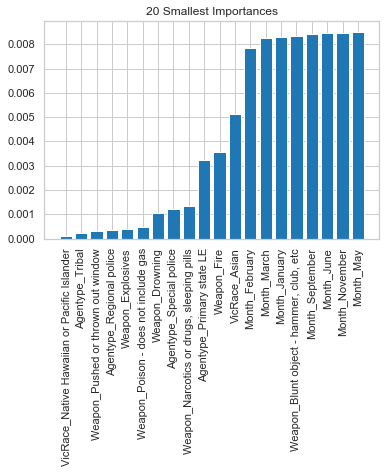

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.045536      1
1    0.1  0.060606   0.088174     99
2   0.15  0.161426   0.129744    477
3    0.2  0.177870   0.175841    967
4   0.25  0.204409   0.226097   1497
5    0.3  0.239308   0.277027   2198
6   0.35  0.288304   0.327279   3916
7    0.4  0.364081   0.374630   5106
8   0.45  0.432090   0.424735   5360
9    0.5  0.482027   0.474597   4145
10  0.55  0.543653   0.524871   3734
11   0.6  0.580865   0.574974   3815
12  0.65  0.638711   0.624318   3601
13   0.7  0.679286   0.673847   2747
14  0.75  0.733333   0.724156   2340
15   0.8  0.796465   0.773294   1867
16  0.85  0.825137   0.822761   1281
17   0.9  0.881954   0.872036    737
18  0.95  0.941441   0.922533    444
19     1  0.986667   0.960883     75


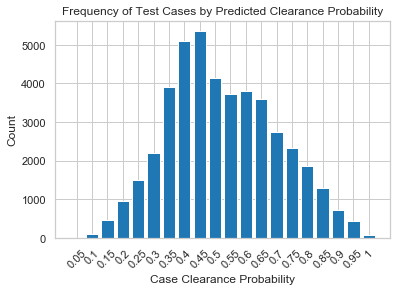

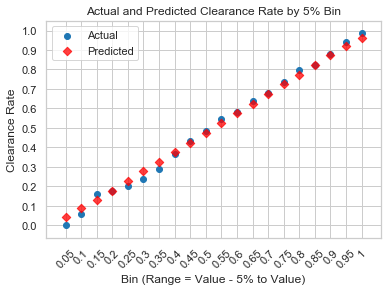

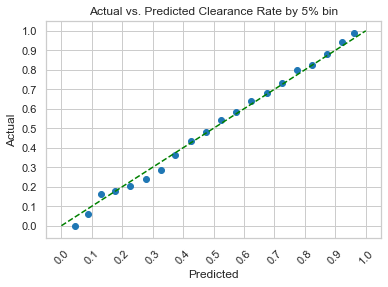

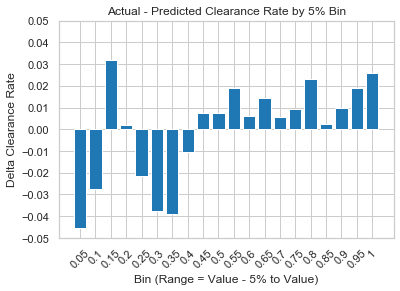

Binned Sum of Squares: 0.009845693585052696
Reporting Time: 20.0 seconds


In [7]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

For some reason, the above two results show that there is still some random aspect to the random forest modeling despite random_state being set to 33

Testing various random forest parameters:

(177626,)
Preprocessing Time: 0.7 seconds
Training Time: 307.9 seconds
Prediction Time: 27.0 seconds
Confusion Matrix:
 [[15384  6820]
 [ 8374 13829]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22204
         1.0       0.67      0.62      0.65     22203

    accuracy                           0.66     44407
   macro avg       0.66      0.66      0.66     44407
weighted avg       0.66      0.66      0.66     44407

Accuracy: 65.78 %
Log Loss: 0.6174440917939651
Brier Score Loss: 0.2145345959243947


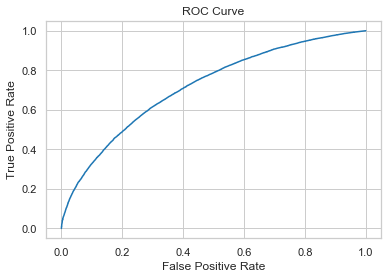

ROC AUC Score: 0.7168698742372881


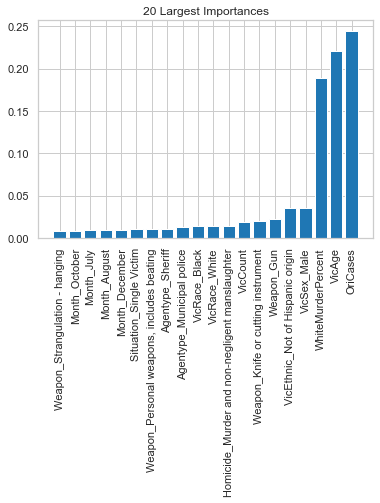

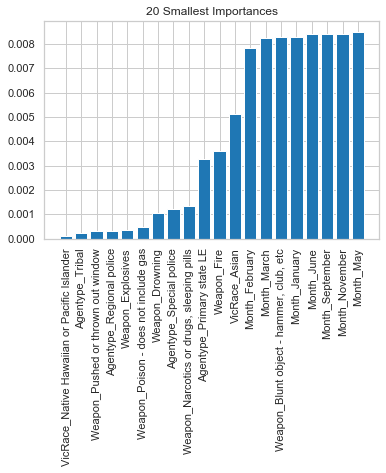

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.048224      1
1    0.1  0.071429   0.088180     98
2   0.15  0.158317   0.130336    499
3    0.2  0.176778   0.176353    956
4   0.25  0.205357   0.226108   1456
5    0.3  0.236526   0.276944   2245
6   0.35  0.288654   0.327119   3887
7    0.4  0.361811   0.374678   5080
8   0.45  0.433271   0.424602   5320
9    0.5  0.480076   0.474247   4216
10  0.55  0.543921   0.524831   3734
11   0.6  0.584073   0.575042   3830
12  0.65  0.636841   0.624369   3621
13   0.7  0.681432   0.673931   2709
14  0.75  0.730118   0.724034   2364
15   0.8  0.799148   0.773596   1877
16  0.85  0.826394   0.823049   1273
17   0.9  0.885402   0.872442    733
18  0.95  0.940639   0.922854    438
19     1  1.000000   0.960337     70


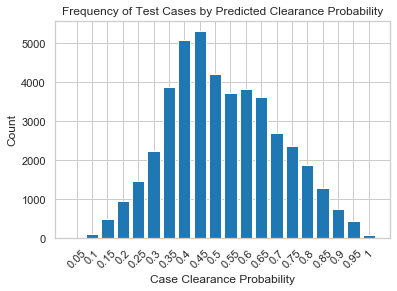

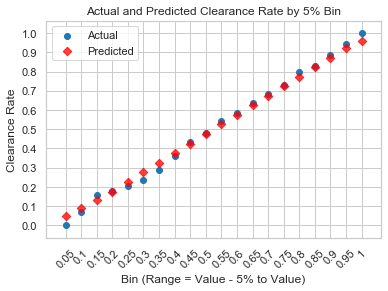

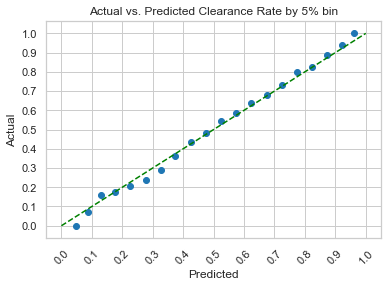

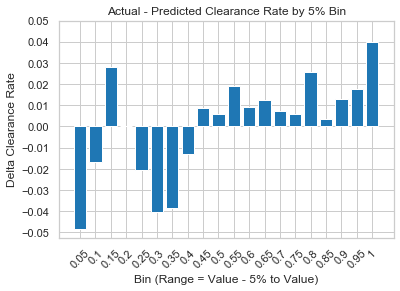

Binned Sum of Squares: 0.010624008903550789
Reporting Time: 31.8 seconds


In [8]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 2000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

#Testing 1000 tree model with various variables left out

Preprocessing Time: 1.0 seconds
Training Time: 140.9 seconds
Prediction Time: 12.5 seconds
Confusion Matrix:
 [[15432  6772]
 [ 9215 12988]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.70      0.66     22204
         1.0       0.66      0.58      0.62     22203

    accuracy                           0.64     44407
   macro avg       0.64      0.64      0.64     44407
weighted avg       0.64      0.64      0.64     44407

Accuracy: 64.0 %
Log Loss: 0.6324015356647338
Brier Score Loss: 0.22147870063582198


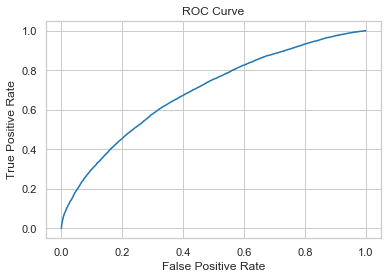

ROC AUC Score: 0.6926134821717165


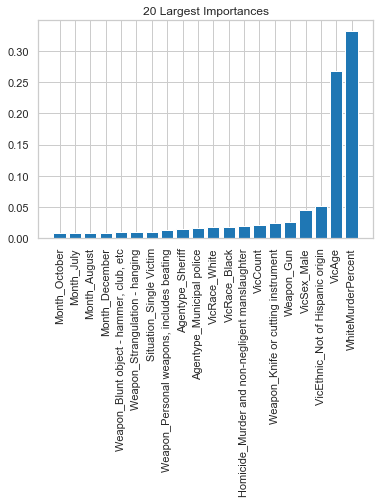

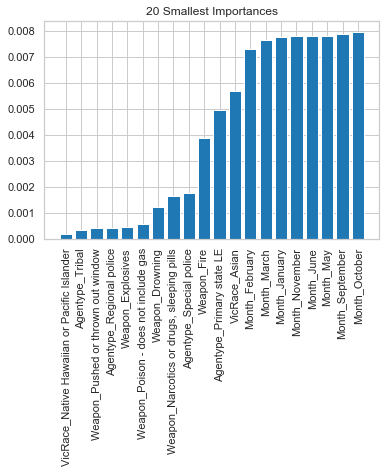

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05       NaN        NaN      0
1    0.1  0.038462   0.084914     26
2   0.15  0.149038   0.124267    208
3    0.2  0.168750   0.177644    640
4   0.25  0.215038   0.227648   1330
5    0.3  0.260153   0.276510   1699
6   0.35  0.317861   0.327812   2693
7    0.4  0.353606   0.379222   6988
8   0.45  0.437684   0.422535   7117
9    0.5  0.482767   0.473960   3946
10  0.55  0.546663   0.525295   4061
11   0.6  0.585026   0.574405   3593
12  0.65  0.618990   0.624898   3328
13   0.7  0.681756   0.674365   2916
14  0.75  0.724551   0.722761   2338
15   0.8  0.768385   0.773175   1455
16  0.85  0.822619   0.823536    840
17   0.9  0.879615   0.874561    623
18  0.95  0.922374   0.923456    438
19     1  0.970238   0.963740    168


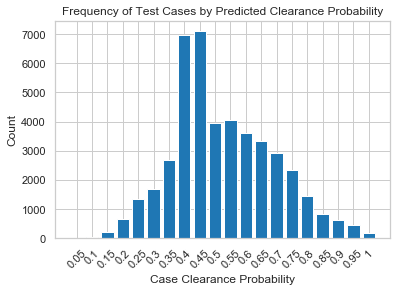

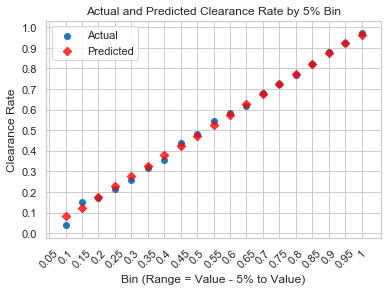

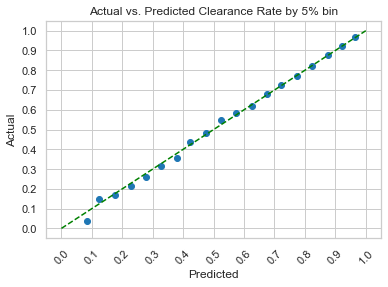

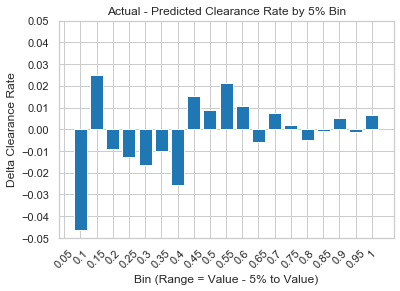

Binned Sum of Squares: 0.005094276364664556
Reporting Time: 15.8 seconds


In [10]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    #'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.7 seconds
Training Time: 135.0 seconds
Prediction Time: 13.1 seconds
Confusion Matrix:
 [[15602  6602]
 [ 9187 13016]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.70      0.66     22204
         1.0       0.66      0.59      0.62     22203

    accuracy                           0.64     44407
   macro avg       0.65      0.64      0.64     44407
weighted avg       0.65      0.64      0.64     44407

Accuracy: 64.44 %
Log Loss: 0.6281014305781043
Brier Score Loss: 0.21927702578325775


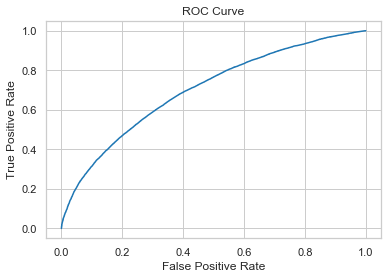

ROC AUC Score: 0.7012770141154985


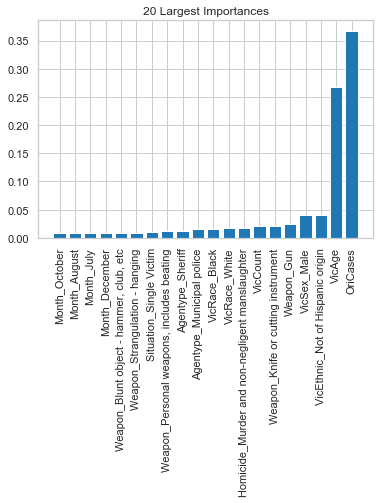

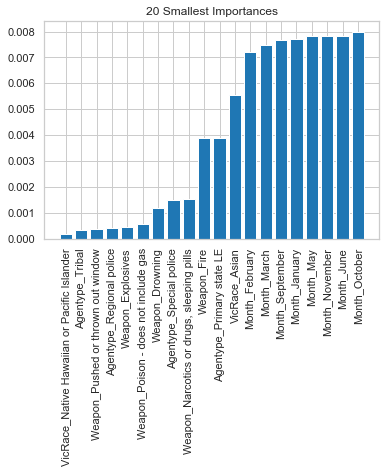

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05       NaN        NaN      0
1    0.1  0.057143   0.084391     35
2   0.15  0.163551   0.126705    214
3    0.2  0.189526   0.174648    401
4   0.25  0.211921   0.228703    906
5    0.3  0.234256   0.277697   2493
6   0.35  0.303513   0.330835   5209
7    0.4  0.379509   0.374058   6071
8   0.45  0.436096   0.423983   5164
9    0.5  0.503026   0.474409   4296
10  0.55  0.543635   0.524657   3747
11   0.6  0.577823   0.575086   3418
12  0.65  0.621970   0.624153   3177
13   0.7  0.662670   0.674012   2502
14  0.75  0.733424   0.724978   2217
15   0.8  0.787486   0.773538   1774
16  0.85  0.804658   0.823615   1331
17   0.9  0.847545   0.872058    774
18  0.95  0.905405   0.924466    518
19     1  0.943750   0.963759    160


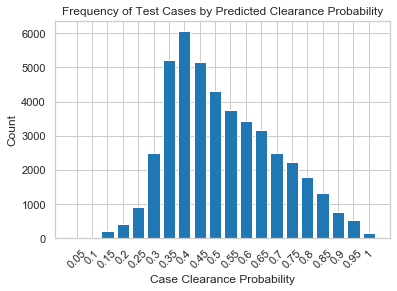

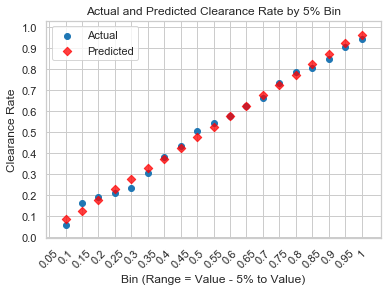

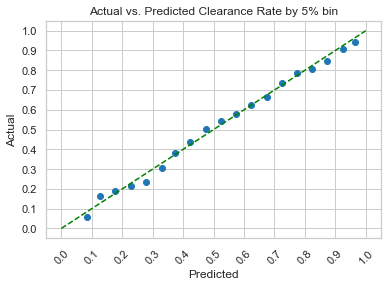

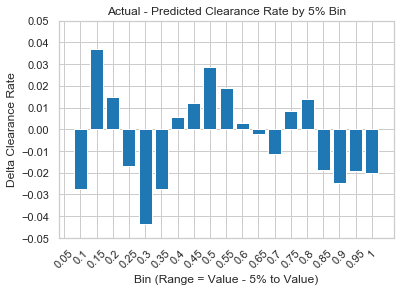

Binned Sum of Squares: 0.008722965491073001
Reporting Time: 15.7 seconds


In [11]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    #'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.6 seconds
Training Time: 130.2 seconds
Prediction Time: 12.5 seconds
Confusion Matrix:
 [[15110  7094]
 [ 8420 13783]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.68      0.66     22204
         1.0       0.66      0.62      0.64     22203

    accuracy                           0.65     44407
   macro avg       0.65      0.65      0.65     44407
weighted avg       0.65      0.65      0.65     44407

Accuracy: 65.06 %
Log Loss: 0.6227340418159351
Brier Score Loss: 0.216832324968394


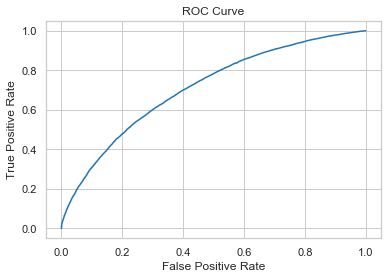

ROC AUC Score: 0.7096950184193601


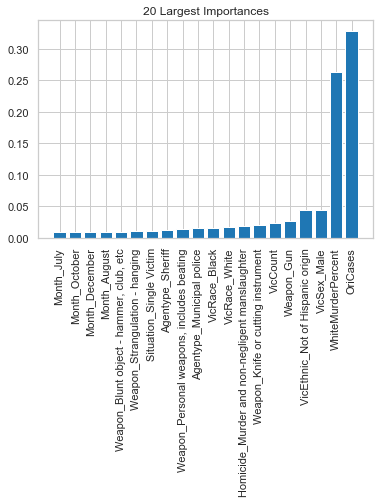

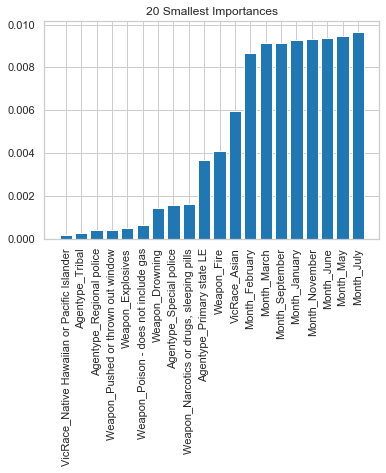

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.062500   0.029881     16
1    0.1  0.140625   0.080268     64
2   0.15  0.162872   0.131426    571
3    0.2  0.176380   0.176928   1304
4   0.25  0.213195   0.225003   1637
5    0.3  0.259926   0.276024   2443
6   0.35  0.293330   0.326601   3808
7    0.4  0.377358   0.375790   4505
8   0.45  0.449267   0.423930   5253
9    0.5  0.490201   0.472136   3929
10  0.55  0.522405   0.524710   3459
11   0.6  0.582857   0.576113   3850
12  0.65  0.638392   0.623830   3631
13   0.7  0.675794   0.673998   2739
14  0.75  0.713803   0.724212   2369
15   0.8  0.750374   0.773401   2003
16  0.85  0.804013   0.823203   1495
17   0.9  0.836663   0.871869    851
18  0.95  0.938619   0.922540    391
19     1  0.988764   0.961663     89


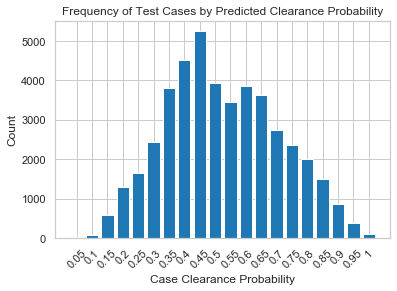

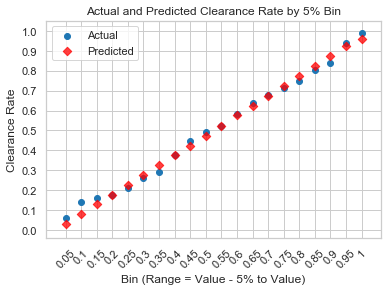

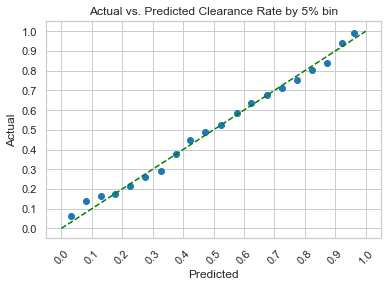

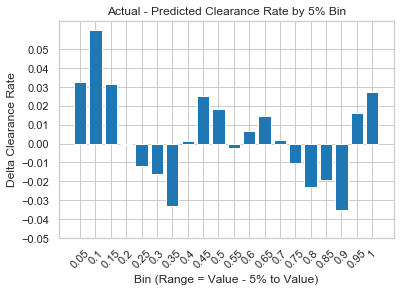

Binned Sum of Squares: 0.01167776942224221
Reporting Time: 16.0 seconds


In [12]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    #'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.7 seconds
Training Time: 135.0 seconds
Prediction Time: 13.4 seconds
Confusion Matrix:
 [[15300  6904]
 [ 8340 13863]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22204
         1.0       0.67      0.62      0.65     22203

    accuracy                           0.66     44407
   macro avg       0.66      0.66      0.66     44407
weighted avg       0.66      0.66      0.66     44407

Accuracy: 65.67 %
Log Loss: 0.619307793416412
Brier Score Loss: 0.2153222639834827


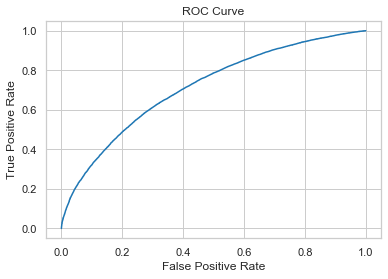

ROC AUC Score: 0.7143201993936609


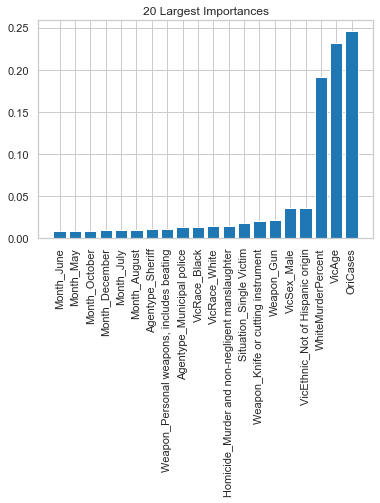

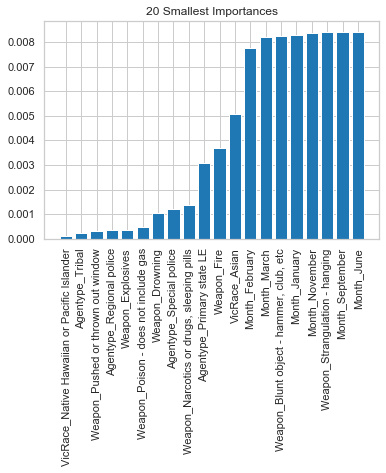

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05       NaN        NaN      0
1    0.1  0.111111   0.088980    144
2   0.15  0.159696   0.130502    526
3    0.2  0.187436   0.176147    971
4   0.25  0.220617   0.226016   1523
5    0.3  0.237925   0.277536   2236
6   0.35  0.289398   0.326766   3839
7    0.4  0.366155   0.374811   5017
8   0.45  0.431597   0.424787   5241
9    0.5  0.477915   0.474112   4143
10  0.55  0.541267   0.524519   3756
11   0.6  0.587790   0.575141   3833
12  0.65  0.633343   0.624650   3551
13   0.7  0.679729   0.673275   2807
14  0.75  0.723475   0.724305   2394
15   0.8  0.795525   0.774232   1922
16  0.85  0.820823   0.823387   1239
17   0.9  0.875339   0.872924    738
18  0.95  0.930649   0.922619    447
19     1  1.000000   0.960972     80


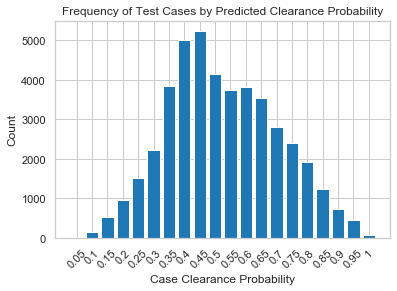

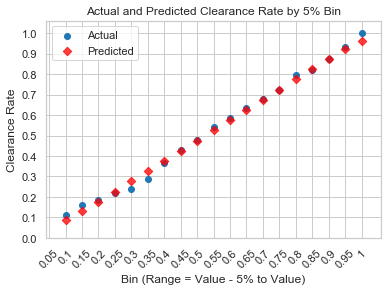

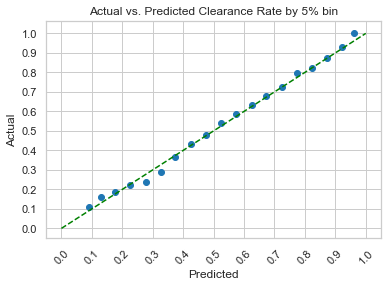

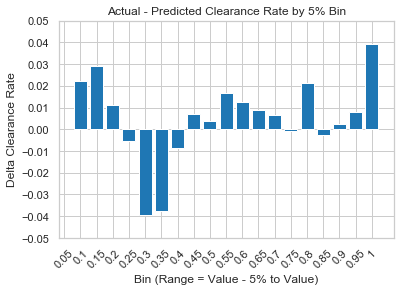

Binned Sum of Squares: 0.007211752058998741
Reporting Time: 17.0 seconds


In [13]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    #'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.6 seconds
Training Time: 130.7 seconds
Prediction Time: 14.6 seconds
Confusion Matrix:
 [[15355  6849]
 [ 8521 13682]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.69      0.67     22204
         1.0       0.67      0.62      0.64     22203

    accuracy                           0.65     44407
   macro avg       0.65      0.65      0.65     44407
weighted avg       0.65      0.65      0.65     44407

Accuracy: 65.39 %
Log Loss: 0.6207270903690808
Brier Score Loss: 0.2160094136500315


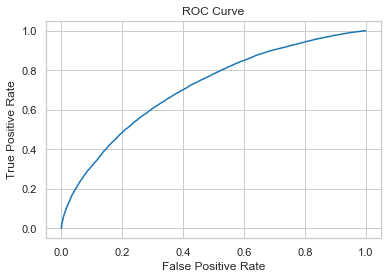

ROC AUC Score: 0.7121226718434451


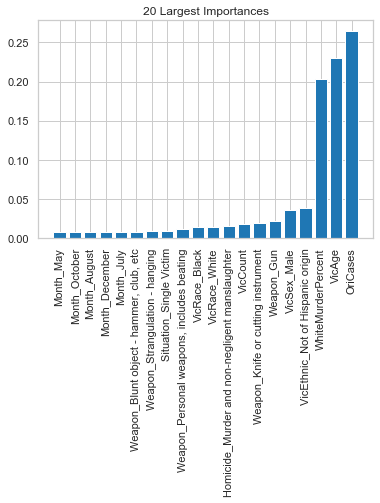

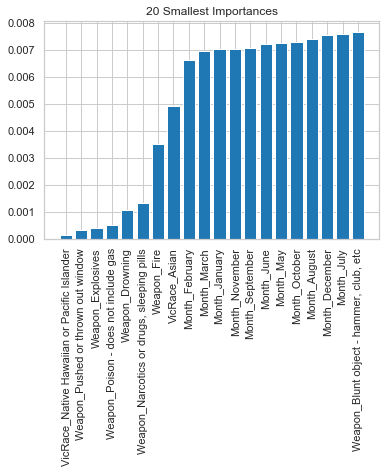

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05       NaN        NaN      0
1    0.1  0.083333   0.088305     48
2   0.15  0.126582   0.130126    316
3    0.2  0.171946   0.177236    884
4   0.25  0.210381   0.226484   1445
5    0.3  0.248157   0.277004   2442
6   0.35  0.280814   0.327541   4081
7    0.4  0.376541   0.374833   5354
8   0.45  0.437559   0.424138   5325
9    0.5  0.483044   0.474106   3981
10  0.55  0.536612   0.525139   3619
11   0.6  0.584056   0.575084   3688
12  0.65  0.644920   0.624960   3740
13   0.7  0.667666   0.673562   3003
14  0.75  0.734388   0.724301   2338
15   0.8  0.782883   0.773531   1741
16  0.85  0.830755   0.825013   1099
17   0.9  0.876165   0.873427    751
18  0.95  0.931718   0.921742    454
19     1  0.969388   0.962007     98


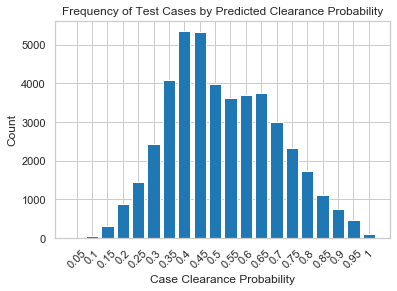

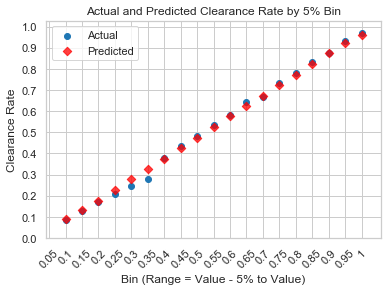

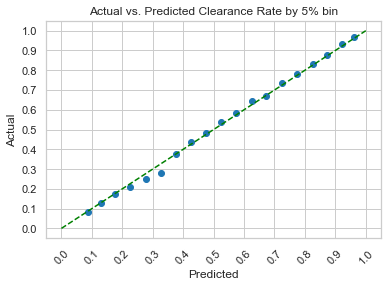

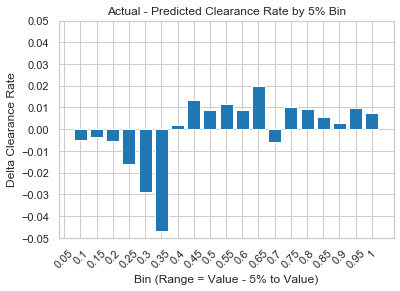

Binned Sum of Squares: 0.004632111326896264
Reporting Time: 18.7 seconds


In [14]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                #'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.7 seconds
Training Time: 126.3 seconds
Prediction Time: 13.7 seconds
Confusion Matrix:
 [[15298  6906]
 [ 8357 13846]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22204
         1.0       0.67      0.62      0.64     22203

    accuracy                           0.66     44407
   macro avg       0.66      0.66      0.66     44407
weighted avg       0.66      0.66      0.66     44407

Accuracy: 65.63 %
Log Loss: 0.6199316620892616
Brier Score Loss: 0.2154036771475124


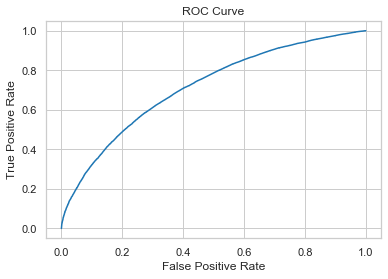

ROC AUC Score: 0.7143692830147474


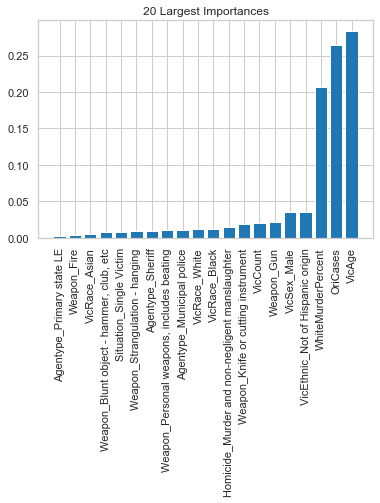

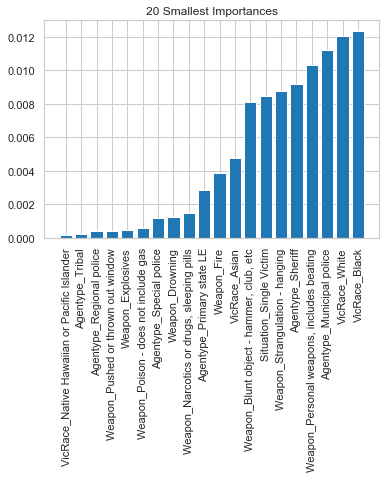

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.042254   0.038272     71
1    0.1  0.197802   0.077243    182
2   0.15  0.173333   0.127074    825
3    0.2  0.204285   0.179848   1307
4   0.25  0.231516   0.225989   2164
5    0.3  0.264354   0.278755   2421
6   0.35  0.309101   0.325355   3604
7    0.4  0.378137   0.374856   4263
8   0.45  0.436598   0.423859   5197
9    0.5  0.489368   0.474087   3621
10  0.55  0.534776   0.525135   3235
11   0.6  0.579688   0.575016   3338
12  0.65  0.629042   0.624786   3464
13   0.7  0.651865   0.674027   2815
14  0.75  0.725866   0.724632   2455
15   0.8  0.740488   0.774029   2050
16  0.85  0.793800   0.824723   1387
17   0.9  0.849074   0.872886   1080
18  0.95  0.896147   0.923280    597
19     1  0.948640   0.966572    331


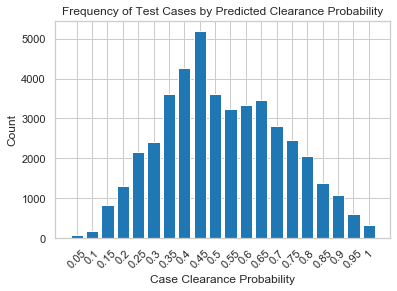

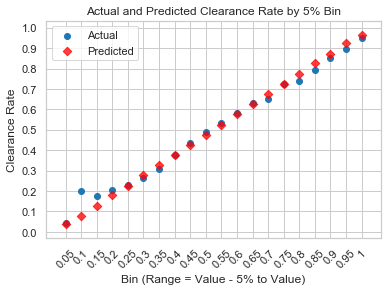

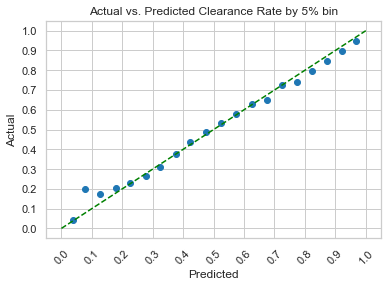

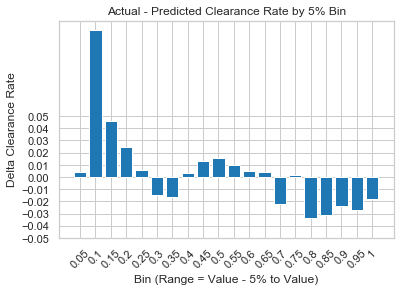

Binned Sum of Squares: 0.022527620719716212
Reporting Time: 17.0 seconds


In [15]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                #'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.8 seconds
Training Time: 142.4 seconds
Prediction Time: 13.3 seconds
Confusion Matrix:
 [[15213  6991]
 [ 8335 13868]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22204
         1.0       0.66      0.62      0.64     22203

    accuracy                           0.65     44407
   macro avg       0.66      0.65      0.65     44407
weighted avg       0.66      0.65      0.65     44407

Accuracy: 65.49 %
Log Loss: 0.6200851675314155
Brier Score Loss: 0.21556060092801735


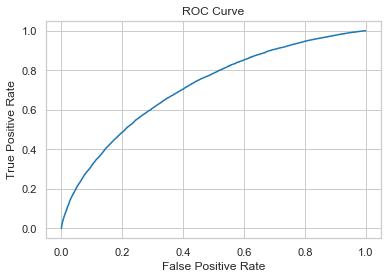

ROC AUC Score: 0.7139822155180624


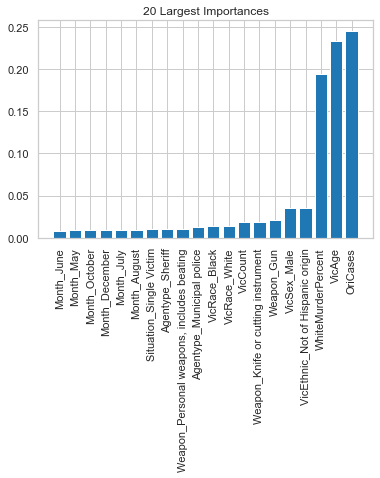

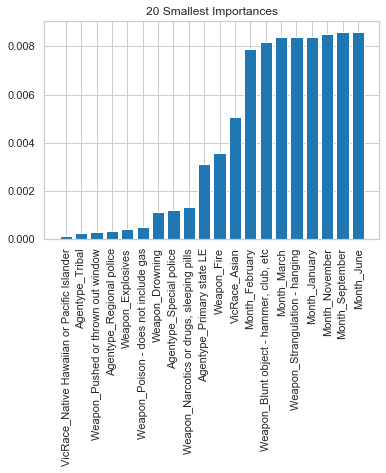

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.200000   0.045428      5
1    0.1  0.108844   0.086570    147
2   0.15  0.158645   0.129845    561
3    0.2  0.174636   0.175957    962
4   0.25  0.223529   0.225483   1530
5    0.3  0.231523   0.277112   2246
6   0.35  0.289798   0.326888   3813
7    0.4  0.370719   0.374950   4993
8   0.45  0.432180   0.424676   5146
9    0.5  0.487093   0.474441   4145
10  0.55  0.531085   0.524879   3796
11   0.6  0.586858   0.575143   3759
12  0.65  0.635650   0.624691   3568
13   0.7  0.683002   0.673894   2918
14  0.75  0.728641   0.724454   2458
15   0.8  0.794456   0.773588   1912
16  0.85  0.815305   0.822204   1359
17   0.9  0.871191   0.872378    722
18  0.95  0.912387   0.921506    331
19     1  1.000000   0.959677     36


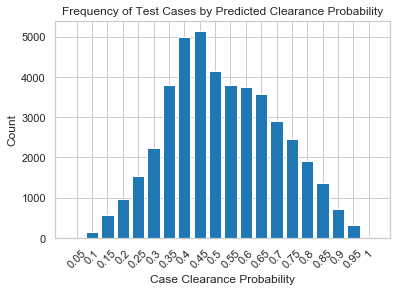

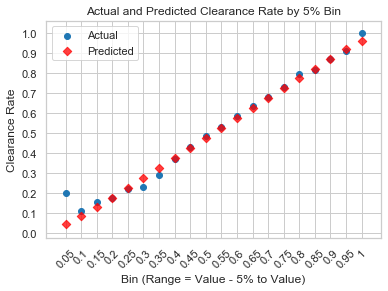

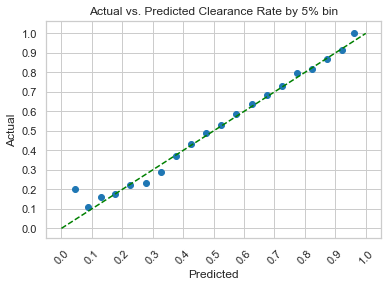

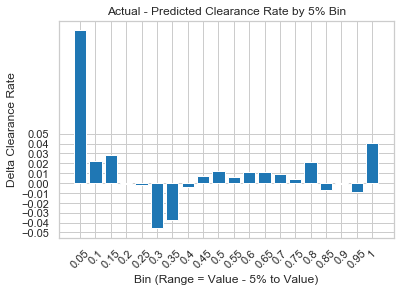

Binned Sum of Squares: 0.03150198486219078
Reporting Time: 17.2 seconds


In [16]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                #'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.7 seconds
Training Time: 142.1 seconds
Prediction Time: 13.3 seconds
Confusion Matrix:
 [[15337  6867]
 [ 8393 13810]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22204
         1.0       0.67      0.62      0.64     22203

    accuracy                           0.66     44407
   macro avg       0.66      0.66      0.66     44407
weighted avg       0.66      0.66      0.66     44407

Accuracy: 65.64 %
Log Loss: 0.617889492808216
Brier Score Loss: 0.21472669274385742


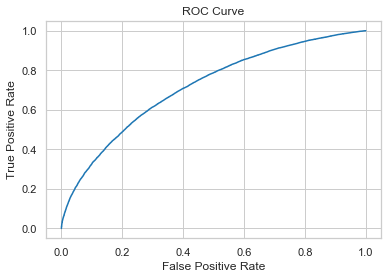

ROC AUC Score: 0.7161754478964604


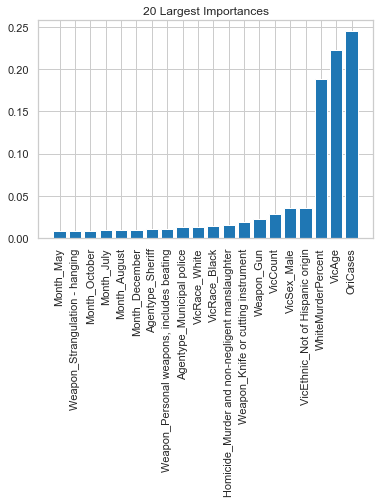

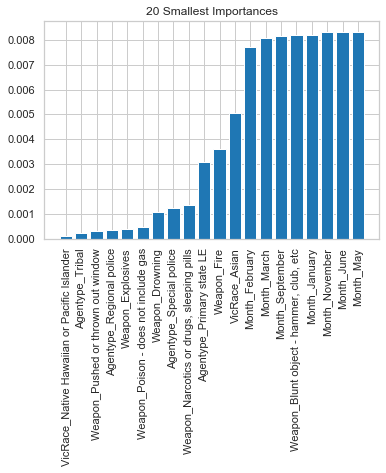

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.045587      1
1    0.1  0.081081   0.091476    111
2   0.15  0.166016   0.129620    512
3    0.2  0.177579   0.176199   1008
4   0.25  0.211268   0.226477   1491
5    0.3  0.234304   0.277659   2198
6   0.35  0.290971   0.326468   3832
7    0.4  0.364935   0.374428   5042
8   0.45  0.432307   0.424848   5392
9    0.5  0.483707   0.474481   4143
10  0.55  0.529949   0.525362   3723
11   0.6  0.590608   0.575106   3769
12  0.65  0.632104   0.624279   3607
13   0.7  0.680595   0.673985   2824
14  0.75  0.733874   0.724318   2341
15   0.8  0.795112   0.774026   1923
16  0.85  0.829960   0.823364   1235
17   0.9  0.882920   0.872184    726
18  0.95  0.928731   0.922194    449
19     1  0.987500   0.959537     80


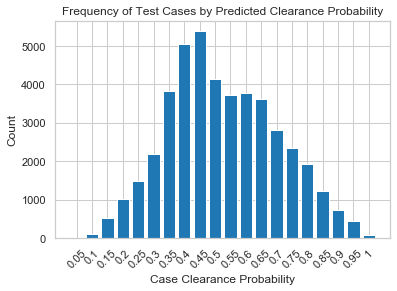

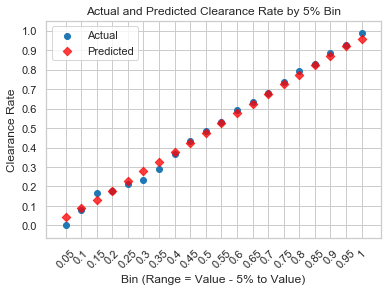

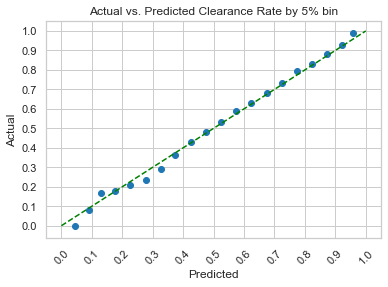

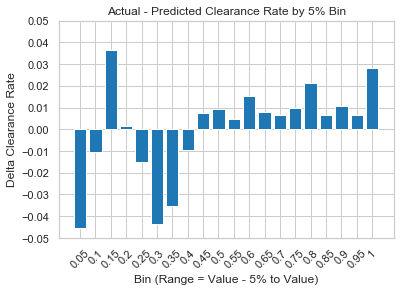

Binned Sum of Squares: 0.009000278355906931
Reporting Time: 16.5 seconds


In [17]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                #'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.7 seconds
Training Time: 138.1 seconds
Prediction Time: 13.5 seconds
Confusion Matrix:
 [[15287  6917]
 [ 8393 13810]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22204
         1.0       0.67      0.62      0.64     22203

    accuracy                           0.66     44407
   macro avg       0.66      0.66      0.65     44407
weighted avg       0.66      0.66      0.65     44407

Accuracy: 65.52 %
Log Loss: 0.6200109187397901
Brier Score Loss: 0.21564762736298362


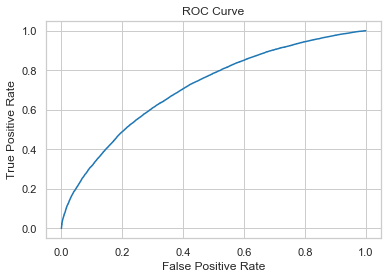

ROC AUC Score: 0.7135254556892305


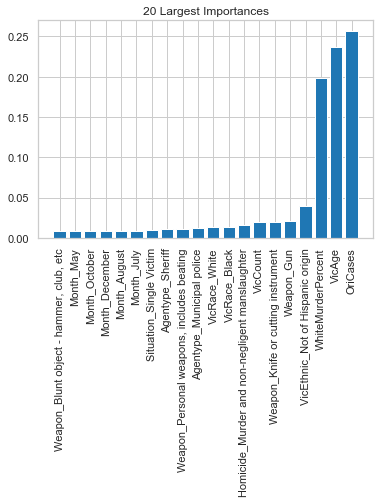

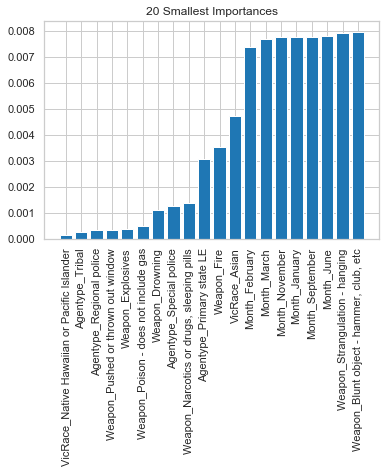

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05       NaN        NaN      0
1    0.1  0.087591   0.086518    137
2   0.15  0.153543   0.128649    508
3    0.2  0.194969   0.176334    954
4   0.25  0.212294   0.226197   1578
5    0.3  0.246985   0.276728   2073
6   0.35  0.283821   0.327349   3622
7    0.4  0.362473   0.376566   5159
8   0.45  0.425492   0.424978   5382
9    0.5  0.487931   0.474379   4267
10  0.55  0.531876   0.525075   3796
11   0.6  0.599521   0.574908   3758
12  0.65  0.640033   0.623634   3667
13   0.7  0.675738   0.673467   3013
14  0.75  0.719044   0.724443   2342
15   0.8  0.797679   0.773307   1982
16  0.85  0.828780   0.821315   1098
17   0.9  0.894934   0.872710    533
18  0.95  0.927536   0.924789    414
19     1  0.959677   0.961789    124


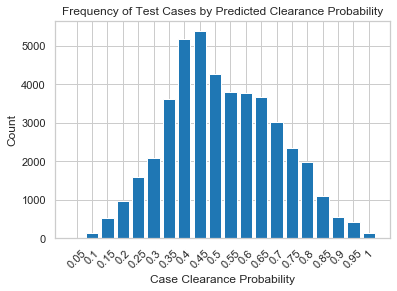

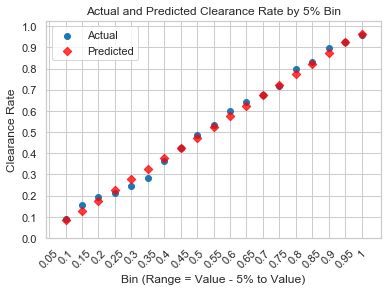

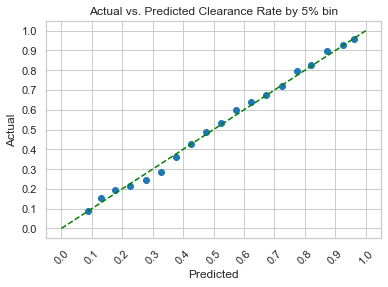

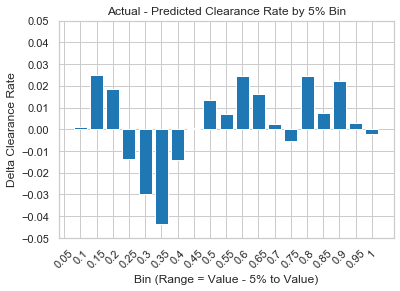

Binned Sum of Squares: 0.006434213274384925
Reporting Time: 16.7 seconds


In [18]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                #'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.6 seconds
Training Time: 141.0 seconds
Prediction Time: 13.2 seconds
Confusion Matrix:
 [[15374  6830]
 [ 8480 13723]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.69      0.67     22204
         1.0       0.67      0.62      0.64     22203

    accuracy                           0.66     44407
   macro avg       0.66      0.66      0.65     44407
weighted avg       0.66      0.66      0.65     44407

Accuracy: 65.52 %
Log Loss: 0.6191590414593797
Brier Score Loss: 0.2153315657109164


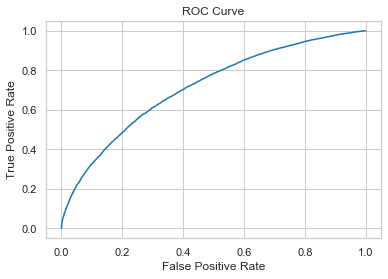

ROC AUC Score: 0.7138957745513461


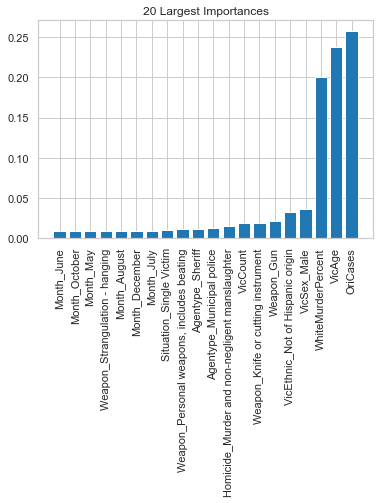

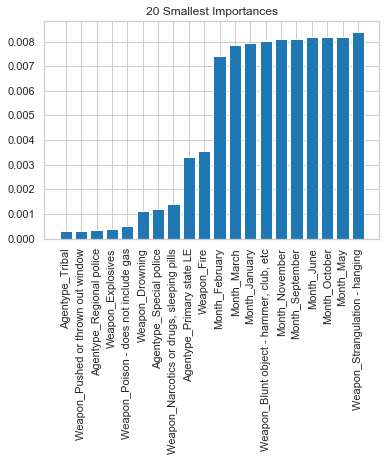

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.043990      2
1    0.1  0.110345   0.088714    145
2   0.15  0.158103   0.131866    506
3    0.2  0.189516   0.175092    992
4   0.25  0.214524   0.225833   1501
5    0.3  0.238162   0.276547   2154
6   0.35  0.287843   0.326867   3759
7    0.4  0.370363   0.375733   4906
8   0.45  0.428183   0.424779   5521
9    0.5  0.480311   0.474966   4368
10  0.55  0.537132   0.525375   3703
11   0.6  0.589572   0.575182   3874
12  0.65  0.629175   0.623899   3503
13   0.7  0.680045   0.674464   2666
14  0.75  0.729013   0.725109   2299
15   0.8  0.785752   0.773669   1909
16  0.85  0.824508   0.822226   1322
17   0.9  0.899861   0.872671    719
18  0.95  0.918630   0.922746    467
19     1  1.000000   0.962975     91


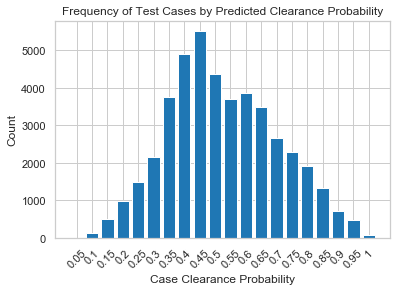

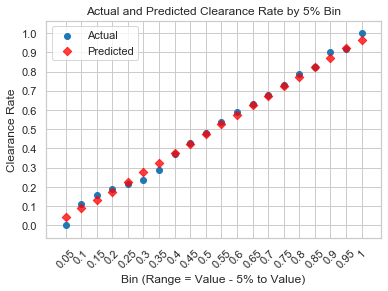

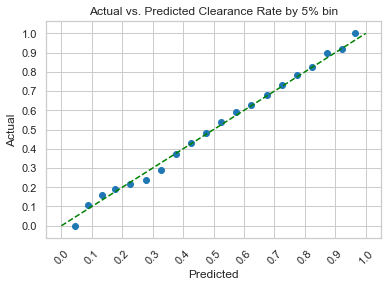

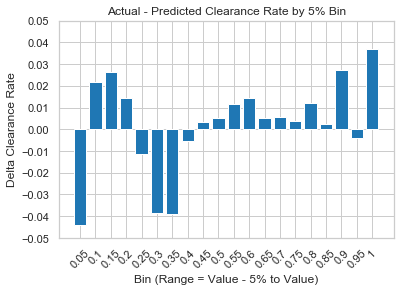

Binned Sum of Squares: 0.009190434963020105
Reporting Time: 18.0 seconds


In [19]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                #'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.7 seconds
Training Time: 139.1 seconds
Prediction Time: 13.0 seconds
Confusion Matrix:
 [[15569  6635]
 [ 8782 13421]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.70      0.67     22204
         1.0       0.67      0.60      0.64     22203

    accuracy                           0.65     44407
   macro avg       0.65      0.65      0.65     44407
weighted avg       0.65      0.65      0.65     44407

Accuracy: 65.28 %
Log Loss: 0.6209771736771277
Brier Score Loss: 0.21615910213299463


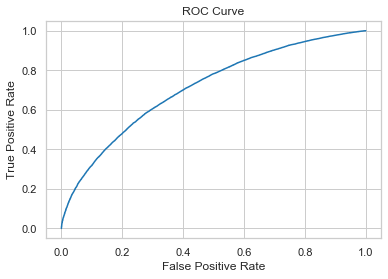

ROC AUC Score: 0.7119321609427067


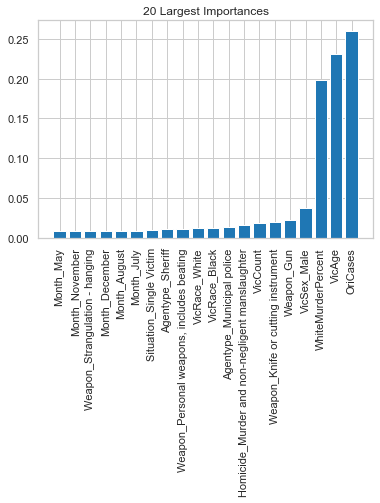

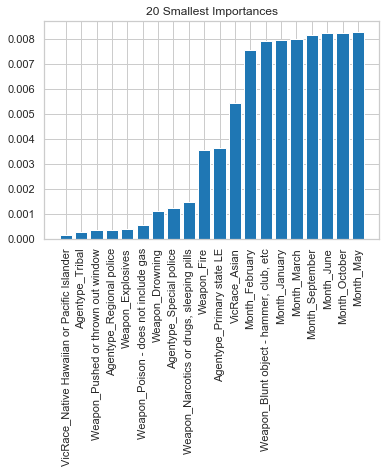

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.043633      3
1    0.1  0.061538   0.083955     65
2   0.15  0.151899   0.128411    553
3    0.2  0.181722   0.175276    941
4   0.25  0.217391   0.225559   1334
5    0.3  0.229123   0.277673   1916
6   0.35  0.282684   0.327352   3159
7    0.4  0.346557   0.375259   4966
8   0.45  0.427128   0.425694   5839
9    0.5  0.481794   0.473218   5575
10  0.55  0.548570   0.524251   4056
11   0.6  0.592329   0.574859   3650
12  0.65  0.636337   0.624025   3352
13   0.7  0.677504   0.673953   2676
14  0.75  0.745381   0.723856   2219
15   0.8  0.793212   0.773586   1591
16  0.85  0.824167   0.823719   1200
17   0.9  0.871012   0.872467    721
18  0.95  0.929487   0.922556    468
19     1  0.975610   0.962274    123


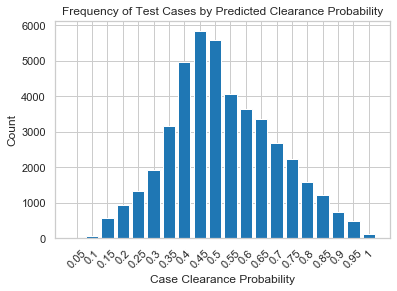

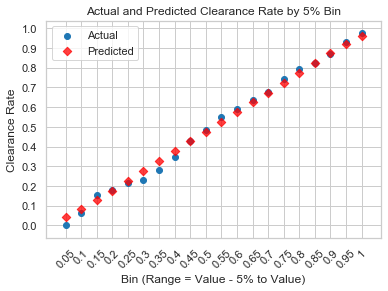

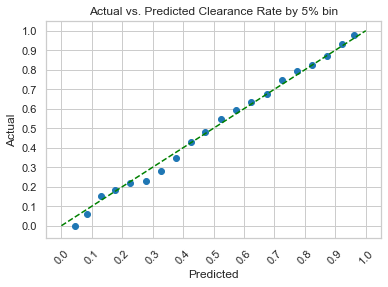

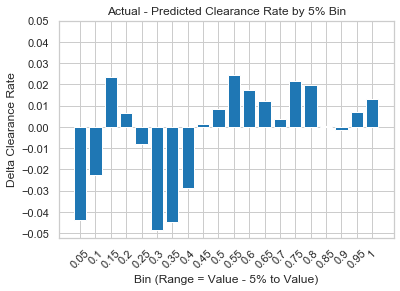

Binned Sum of Squares: 0.010455430249165041
Reporting Time: 16.2 seconds


In [20]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                #'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)

Preprocessing Time: 0.6 seconds
Training Time: 126.9 seconds
Prediction Time: 13.6 seconds
Confusion Matrix:
 [[15132  7072]
 [ 8636 13567]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.68      0.66     22204
         1.0       0.66      0.61      0.63     22203

    accuracy                           0.65     44407
   macro avg       0.65      0.65      0.65     44407
weighted avg       0.65      0.65      0.65     44407

Accuracy: 64.63 %
Log Loss: 0.6292851382076745
Brier Score Loss: 0.21980572196293185


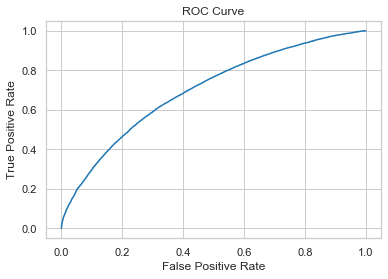

ROC AUC Score: 0.6991625694885777


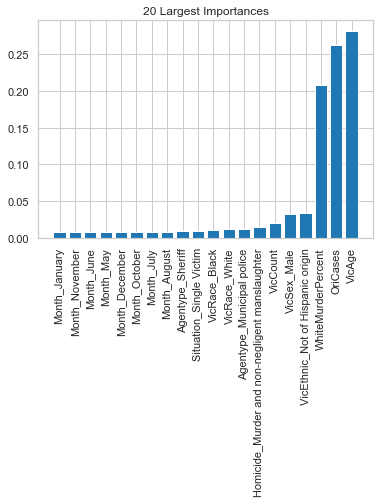

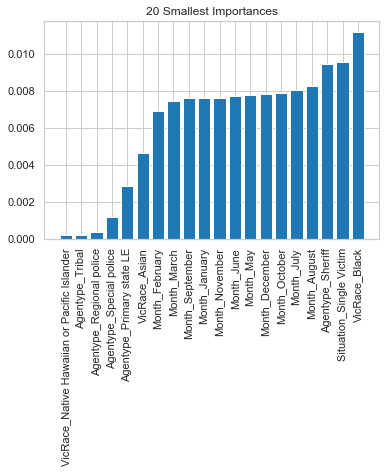

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.090909   0.040632     11
1    0.1  0.146119   0.081957    219
2   0.15  0.164179   0.128209    603
3    0.2  0.207459   0.175798    858
4   0.25  0.213343   0.225780   1364
5    0.3  0.277778   0.276357   2106
6   0.35  0.307269   0.327127   3453
7    0.4  0.364058   0.376109   4958
8   0.45  0.433945   0.424563   5609
9    0.5  0.468716   0.473421   4587
10  0.55  0.537946   0.524310   3729
11   0.6  0.580993   0.575397   3525
12  0.65  0.631227   0.624915   3734
13   0.7  0.676281   0.673972   3259
14  0.75  0.714948   0.723586   2589
15   0.8  0.763025   0.772711   1785
16  0.85  0.817748   0.822593   1048
17   0.9  0.882033   0.872647    551
18  0.95  0.947522   0.921330    343
19     1  0.934211   0.962650     76


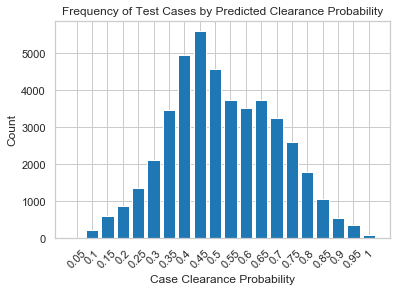

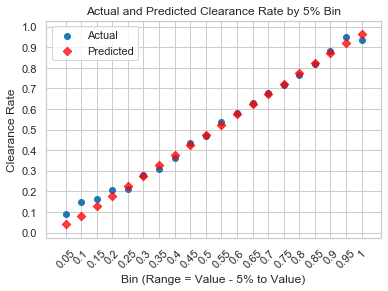

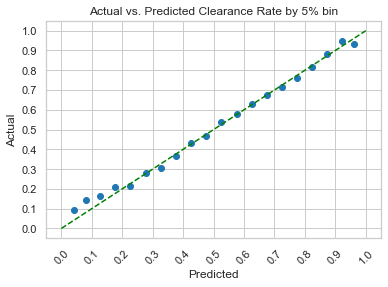

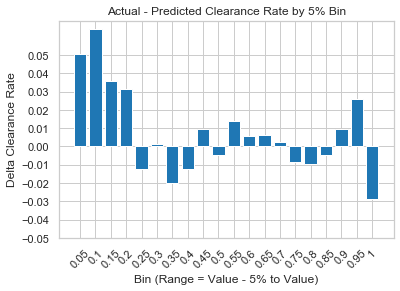

Binned Sum of Squares: 0.011784441225899441
Reporting Time: 17.2 seconds


In [21]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                #'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

TrainVal(forest_1, df_categorical, df_numerical, y)